# Notebook 2 — Returns & Profitability (Last 12 Months)

This notebook answers:
1) Which **products** drive top revenue and how their **margin proxy** compares  
2) Which **traffic sources** have high revenue but low AOV (or vice versa)  
3) Whether **slower fulfillment** correlates with **higher returns**  
4) How **revenue and margin** evolve over time (monthly), by **category** and **traffic source**


### 1) Code cell — Setup + Paths + DB (single source of truth)


In [2]:
from pathlib import Path
import os

import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# --- Resolve repo root ---
ROOT = Path.cwd()
while ROOT.name.lower() != "ecommerceproject" and not (ROOT / "analysis").exists():
    if ROOT.parent == ROOT:
        raise RuntimeError(
            "Could not find repo root.\n"
            "Open the notebook from inside: C:\\dev\\ecommerceproject"
        )
    ROOT = ROOT.parent

# --- Output folders (with full paths) ---
OUT_DIR     = ROOT / "analysis" / "outputs"
OUT_TABLES  = OUT_DIR / "tables"
OUT_FIGS    = OUT_DIR / "figures"

OUT_TABLES.mkdir(parents=True, exist_ok=True)
OUT_FIGS.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("Tables dir:", OUT_TABLES)   # e.g., C:\dev\ecommerceproject\analysis\outputs\tables
print("Figures dir:", OUT_FIGS)    # e.g., C:\dev\ecommerceproject\analysis\outputs\figures

# --- Load env + connect ---
load_dotenv(ROOT / ".env")
db_url = os.getenv("DATABASE_URL")
if not db_url:
    raise RuntimeError("DATABASE_URL not found. Check: C:\\dev\\ecommerceproject\\.env")

engine = create_engine(db_url)

# --- Helper: run SQL and return DataFrame ---
def run_sql(sql: str) -> pd.DataFrame:
    with engine.connect() as conn:
        return pd.read_sql_query(text(sql), conn)

# Quick connectivity check
run_sql("SELECT 1 AS ok;")
print("✅ Connected")


ROOT: c:\dev\ecommerceproject
Tables dir: c:\dev\ecommerceproject\analysis\outputs\tables
Figures dir: c:\dev\ecommerceproject\analysis\outputs\figures
✅ Connected


### 3) Pull the base dataset (last 12 months window)


We pull a minimal “fact” dataset with:
- revenue = `sale_price`
- margin proxy = `sale_price - inventory_cost`
- return flag = `returned_at IS NOT NULL`
- fulfillment speed = `(delivered_at - shipped_at)` in days


In [3]:
sql_base = """
WITH bounds AS (
  SELECT MAX(created_at)::timestamptz AS max_ts
  FROM thelook_analytics.v_fact_order_items_enriched
),
base AS (
  SELECT
    order_item_id,
    order_id,
    user_id,
    product_id,
    inventory_item_id,

    created_at::timestamptz   AS created_at,
    shipped_at::timestamptz   AS shipped_at,
    delivered_at::timestamptz AS delivered_at,
    returned_at::timestamptz  AS returned_at,

    sale_price::numeric       AS sale_price,
    inventory_cost::numeric   AS inventory_cost,
    (sale_price - inventory_cost)::numeric AS margin_proxy,

    category,
    department,
    brand,

    distribution_center_id,
    distribution_center_name,

    CASE WHEN returned_at IS NOT NULL THEN 1 ELSE 0 END AS is_returned,

    EXTRACT(EPOCH FROM (delivered_at::timestamptz - shipped_at::timestamptz))/86400.0 AS ship_to_deliver_days
  FROM thelook_analytics.v_fact_order_items_enriched
  WHERE created_at::timestamptz >= (SELECT max_ts - INTERVAL '12 months' FROM bounds)
),
final AS (
  SELECT
    b.*,
    u.traffic_source::text AS user_traffic_source
  FROM base b
  LEFT JOIN thelook_raw.users u
    ON u.id = b.user_id
)
SELECT * FROM final;
"""

df = run_sql(sql_base)

print("df shape:", df.shape)
display(df.head(5))
display(df[["user_traffic_source"]].head(10))


df shape: (95717, 20)


,order_item_id,order_id,user_id,product_id,inventory_item_id,created_at,shipped_at,delivered_at,returned_at,sale_price,inventory_cost,margin_proxy,category,department,brand,distribution_center_id,distribution_center_name,is_returned,ship_to_deliver_days,user_traffic_source
0,10447,7201,5739,29019,28171,2023-07-19 14:45:08+00:00,2023-07-20 00:39:00+00:00,2023-07-20 09:11:00+00:00,NaT,34.95,12.3024,22.6476,Accessories,Men,JiMarti,4,Los Angeles CA,0,0.355556,Search
1,32658,22529,17980,14097,88049,2024-01-12 23:36:46+00:00,2024-01-14 17:22:00+00:00,NaT,NaT,34.95,12.3373,22.6127,Accessories,Women,JiMarti,4,Los Angeles CA,0,NaN,Search
2,57274,39437,31564,14097,154559,2023-03-06 00:30:09+00:00,2023-03-09 00:14:00+00:00,NaT,NaT,34.95,12.3373,22.6127,Accessories,Women,JiMarti,4,Los Angeles CA,0,NaN,Search
3,86303,59355,47422,14097,232893,2024-01-13 00:29:06+00:00,NaT,NaT,NaT,34.95,12.3373,22.6127,Accessories,Women,JiMarti,4,Los Angeles CA,0,NaN,Search
4,97669,67223,53708,29019,263529,2023-05-05 07:57:07+00:00,2023-05-05 19:54:00+00:00,2023-05-09 11:19:00+00:00,NaT,34.95,12.3024,22.6476,Accessories,Men,JiMarti,4,Los Angeles CA,0,3.642361,Facebook


,user_traffic_source
0,Search
1,Search
2,Search
3,Search
4,Facebook
5,Search
6,Facebook
7,Facebook
8,Email
9,Search


### 4) Sanity checks + Quick Insights (uses variables)


In [4]:
# Basic checks
required_cols = [
    "order_item_id","order_id","user_id","product_id",
    "created_at","sale_price","inventory_cost","margin_proxy",
    "is_returned","user_traffic_source"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing columns in df: {missing}")

# Convert dates safely
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# KPIs (last 12 months window from max date used in SQL)
kpis = {
    "rows_order_items": int(len(df)),
    "unique_orders": int(df["order_id"].nunique()),
    "unique_users": int(df["user_id"].nunique()),
    "returned_items": int(df["is_returned"].sum()),
    "return_rate": float(df["is_returned"].mean()),
    "revenue": float(df["sale_price"].sum()),
    "cost_proxy": float(df["inventory_cost"].sum()),
    "margin_proxy": float(df["margin_proxy"].sum()),
    "margin_rate_proxy": float(df["margin_proxy"].sum() / df["sale_price"].sum()) if df["sale_price"].sum() else None,
    "traffic_sources": int(df["user_traffic_source"].nunique(dropna=True)),
    "traffic_source_null_share": float(df["user_traffic_source"].isna().mean()),
}

kpis

# Quick insights text (built from computed KPIs)
rev = kpis["revenue"]
mr  = kpis["margin_rate_proxy"]
rr  = kpis["return_rate"]
n_orders = kpis["unique_orders"]
n_users  = kpis["unique_users"]
n_items  = kpis["rows_order_items"]

top_sources = (
    df["user_traffic_source"]
    .fillna("UNKNOWN")
    .value_counts()
    .head(5)
)

print("Quick Insights (last 12 months window)")
print(f"- Revenue: ${rev:,.2f}")
print(f"- Proxy margin rate: {mr:.2%} (sale_price - inventory_cost)")
print(f"- Return rate: {rr:.2%} across {n_items:,} order-items")
print(f"- Orders: {n_orders:,} | Customers: {n_users:,}")
print(f"- Traffic sources: {kpis['traffic_sources']} (NULL share: {kpis['traffic_source_null_share']:.1%})")
print("- Top traffic sources by item volume:")
display(top_sources.to_frame("order_items"))


Quick Insights (last 12 months window)
- Revenue: $5,738,761.64
- Proxy margin rate: 51.91% (sale_price - inventory_cost)
- Return rate: 10.16% across 95,717 order-items
- Orders: 66,019 | Customers: 48,277
- Traffic sources: 5 (NULL share: 0.0%)
- Top traffic sources by item volume:


,order_items
user_traffic_source,
Search,67411
Organic,14319
Facebook,5528
Email,4651
Display,3808


## 1) Which products drive top revenue + margin proxy?

### Top products by revenue + margin proxy (not just categories)
If product names are available in `thelook_raw.products`, we join to show them.
If your schema is different, swap `thelook_raw.products` to the right table.

In [5]:
# If you don't have product_name in this dataset, product_id is still valid for ranking.
# Optional: If product_name exists later, swap groupby keys to ["product_id","product_name"].

top_products = (
    df.groupby("product_id", as_index=False)
      .agg(
          order_items=("order_item_id","count"),
          orders=("order_id","nunique"),
          revenue=("sale_price","sum"),
          margin_proxy=("margin_proxy","sum"),
          return_rate=("is_returned","mean"),
      )
)

top_products["margin_rate_proxy"] = top_products["margin_proxy"] / top_products["revenue"]
top_products = top_products.sort_values("revenue", ascending=False).head(25)

display(top_products)
top_products.to_csv(OUT_TABLES / "q1_top_products_by_revenue.csv", index=False)
print("Saved:", OUT_TABLES / "q1_top_products_by_revenue.csv")


,product_id,order_items,orders,revenue,margin_proxy,return_rate,margin_rate_proxy
23444,24428,8,8,7224.0,3864.840,0.000000,0.535
8275,8721,9,9,7155.0,3713.445,0.111111,0.519
16290,17094,7,7,6321.0,2648.499,0.000000,0.419
4952,5213,7,7,6265.0,3226.475,0.285714,0.515
17228,18062,6,6,5418.0,3066.588,0.000000,0.566
23893,24899,6,6,5418.0,2075.094,0.166667,0.383
23136,24110,5,5,4950.0,2559.150,0.000000,0.517
22834,23803,6,6,4890.0,2621.040,0.166667,0.536
19558,20450,12,12,4776.0,2961.120,0.000000,0.620
7879,8300,6,6,4770.0,2394.540,0.333333,0.502


Saved: c:\dev\ecommerceproject\analysis\outputs\tables\q1_top_products_by_revenue.csv


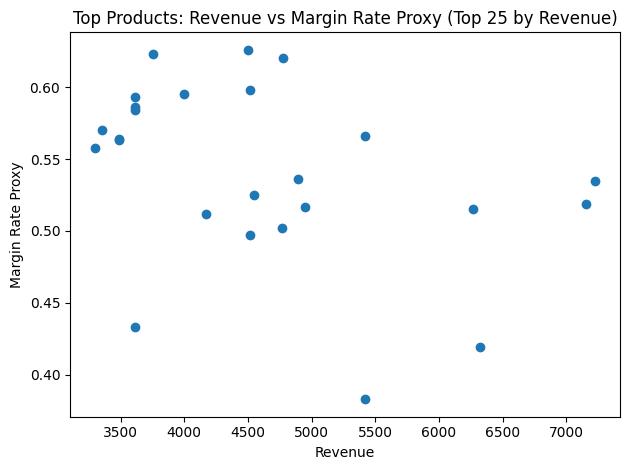

Saved: c:\dev\ecommerceproject\analysis\outputs\figures\q1_top_products_revenue_vs_margin_rate.png


In [6]:
fig = plt.figure()
plt.scatter(top_products["revenue"], top_products["margin_rate_proxy"])
plt.title("Top Products: Revenue vs Margin Rate Proxy (Top 25 by Revenue)")
plt.xlabel("Revenue")
plt.ylabel("Margin Rate Proxy")
plt.tight_layout()
plt.show()

# Save chart
fig_path = OUT_FIGS / "q1_top_products_revenue_vs_margin_rate.png"
fig.savefig(fig_path, bbox_inches="tight")
print("Saved:", fig_path)


,product_id,product_name,order_items,orders,revenue,margin_proxy,return_rate,margin_rate_proxy,product_label
23444,24428,The North Face Apex Bionic Mens Soft Shell Ski...,8,8,7224.0,3864.840,0.000000,0.535,The North Face Apex Bionic Mens Soft Shell Ski...
8275,8721,Nobis Merideth Parka,9,9,7155.0,3713.445,0.111111,0.519,Nobis Merideth Parka (ID 8721)
16290,17094,The North Face Apex Bionic Soft Shell Jacket -...,7,7,6321.0,2648.499,0.000000,0.419,The North Face Apex Bionic Soft Shell Jacket -...
4952,5213,Catherine Malandrino Women's Skinny Stretch Le...,7,7,6265.0,3226.475,0.285714,0.515,Catherine Malandrino Women's Skinny Stretch Le...
17228,18062,The North Face Apex Bionic Soft Shell Jacket -...,6,6,5418.0,3066.588,0.000000,0.566,The North Face Apex Bionic Soft Shell Jacket -...
23893,24899,Nike Jordan Retro 11 Bred Bootie Socks,6,6,5418.0,2075.094,0.166667,0.383,Nike Jordan Retro 11 Bred Bootie Socks (ID 24899)
23136,24110,Woolrich Arctic Parka DF,5,5,4950.0,2559.150,0.000000,0.517,Woolrich Arctic Parka DF (ID 24110)
22834,23803,Canada Goose Men's The Chateau Jacket,6,6,4890.0,2621.040,0.166667,0.536,Canada Goose Men's The Chateau Jacket (ID 23803)
19558,20450,7 For All Mankind Men's Ombre Plaid Blazer,12,12,4776.0,2961.120,0.000000,0.620,7 For All Mankind Men's Ombre Plaid Blazer (ID...
7879,8300,Canada Goose Women's Expedition Parka,6,6,4770.0,2394.540,0.333333,0.502,Canada Goose Women's Expedition Parka (ID 8300)


Saved: c:\dev\ecommerceproject\analysis\outputs\tables\q1_top_products_by_revenue.csv


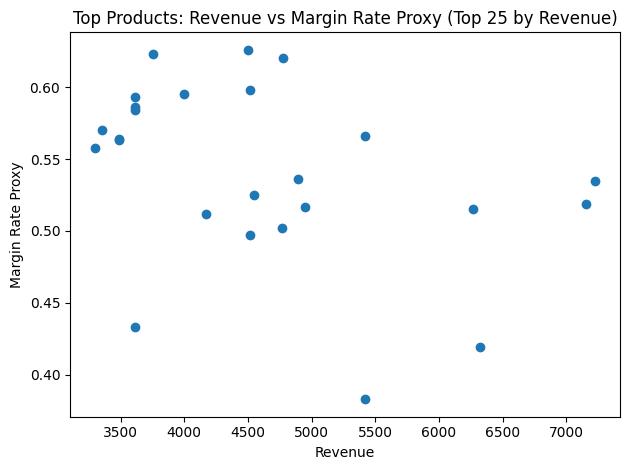

Saved: c:\dev\ecommerceproject\analysis\outputs\figures\q1_top_products_revenue_vs_margin_rate.png


In [7]:
# Q1 — Top products by revenue (robust product_name enrichment)
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

df_enriched = df.copy()

def _table_exists(schema: str, table: str) -> bool:
    q = """
    SELECT 1
    FROM information_schema.tables
    WHERE table_schema = :schema AND table_name = :table
    LIMIT 1;
    """
    with engine.connect() as conn:
        r = conn.execute(text(q), {"schema": schema, "table": table}).fetchone()
    return r is not None

def _get_columns(schema: str, table: str) -> list[str]:
    q = """
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = :schema AND table_name = :table
    ORDER BY ordinal_position;
    """
    with engine.connect() as conn:
        rows = conn.execute(text(q), {"schema": schema, "table": table}).fetchall()
    return [r[0] for r in rows]

got_name = False

# --- 1) DB enrichment (auto-detect columns) ---
schema = "thelook_raw"
table = "products"

if _table_exists(schema, table):
    cols = _get_columns(schema, table)
    cols_set = set(c.lower() for c in cols)

    key_candidates = ["product_id", "id", "productid"]
    name_candidates = ["product_name", "name", "title"]

    key_col = next((c for c in key_candidates if c in cols_set), None)
    name_col = next((c for c in name_candidates if c in cols_set), None)

    if key_col and name_col:
        # map detected lowercase col name back to actual casing from information_schema
        key_col_real = next(c for c in cols if c.lower() == key_col)
        name_col_real = next(c for c in cols if c.lower() == name_col)

        sql_prod = f"""
        SELECT
            {key_col_real} AS product_id,
            {name_col_real} AS product_name
        FROM {schema}.{table}
        """
        with engine.connect() as conn:
            prod_dim = pd.read_sql_query(text(sql_prod), conn)

        # ensure types align for merge
        df_enriched["product_id"] = df_enriched["product_id"].astype("int64", errors="ignore")
        prod_dim["product_id"] = prod_dim["product_id"].astype("int64", errors="ignore")

        df_enriched = df_enriched.merge(prod_dim, on="product_id", how="left")
        got_name = True
    else:
        print(f"⚠️ DB products table found, but couldn't detect key+name columns. Columns: {cols}")

# --- 2) Local CSV fallback (explicit route) ---
if not got_name:
    products_csv = ROOT / "data" / "raw" / "products.csv"  # C:\dev\ecommerceproject\data\raw\products.csv
    if products_csv.exists():
        prod_dim = pd.read_csv(products_csv)

        # detect key + name in CSV
        key_candidates = ["product_id", "id", "productid"]
        name_candidates = ["product_name", "name", "title", "product", "product_title"]

        key_col = next((c for c in key_candidates if c in prod_dim.columns), None)
        name_col = next((c for c in name_candidates if c in prod_dim.columns), None)

        if key_col and name_col:
            prod_dim = prod_dim[[key_col, name_col]].rename(columns={key_col: "product_id", name_col: "product_name"})
            df_enriched = df_enriched.merge(prod_dim, on="product_id", how="left")
            got_name = True
        else:
            print(f"⚠️ products.csv exists but couldn't detect key+name columns. Columns: {list(prod_dim.columns)}")
    else:
        print(f"⚠️ products.csv not found at: {products_csv}")

# --- 3) Aggregate top products ---
group_keys = ["product_id"]
if "product_name" in df_enriched.columns:
    group_keys.append("product_name")

top_products = (
    df_enriched.groupby(group_keys, as_index=False)
      .agg(
          order_items=("order_item_id","count"),
          orders=("order_id","nunique"),
          revenue=("sale_price","sum"),
          margin_proxy=("margin_proxy","sum"),
          return_rate=("is_returned","mean"),
      )
)

top_products["margin_rate_proxy"] = top_products["margin_proxy"] / top_products["revenue"]
top_products = top_products.sort_values("revenue", ascending=False).head(25)

# --- 4) Label for Metabase tooltips ---
if "product_name" in top_products.columns:
    top_products["product_label"] = top_products["product_name"].fillna("Unknown") + " (ID " + top_products["product_id"].astype(str) + ")"
else:
    top_products["product_label"] = "Product ID " + top_products["product_id"].astype(str)

display(top_products)

# --- 5) Save outputs (explicit routes already set by OUT_TABLES/OUT_FIGS) ---
out_csv = OUT_TABLES / "q1_top_products_by_revenue.csv"
top_products.to_csv(out_csv, index=False)
print("Saved:", out_csv)

fig = plt.figure()
plt.scatter(top_products["revenue"], top_products["margin_rate_proxy"])
plt.title("Top Products: Revenue vs Margin Rate Proxy (Top 25 by Revenue)")
plt.xlabel("Revenue")
plt.ylabel("Margin Rate Proxy")
plt.tight_layout()
plt.show()

fig_path = OUT_FIGS / "q1_top_products_revenue_vs_margin_rate.png"
fig.savefig(fig_path, bbox_inches="tight")
print("Saved:", fig_path)


## 2) Traffic sources: high revenue but low AOV (or vice versa)?

## Traffic source quality (Revenue vs AOV vs Return Rate)

Goal: identify sources with:
- High revenue but low AOV (many small orders)
- Low revenue but high AOV (fewer high-value orders)
- High return rates (quality risk)


In [8]:
if df["user_traffic_source"].isna().all():
    print("⚠️ user_traffic_source is fully NULL. Q2 skipped.")
else:
    ts = df.copy()
    ts["user_traffic_source"] = ts["user_traffic_source"].fillna("UNKNOWN")

    traffic_perf = (
        ts.groupby("user_traffic_source", as_index=False)
          .agg(
              order_items=("order_item_id","count"),
              orders=("order_id","nunique"),
              users=("user_id","nunique"),
              revenue=("sale_price","sum"),
              margin_proxy=("margin_proxy","sum"),
              return_rate=("is_returned","mean"),
          )
    )

    traffic_perf["aov"] = traffic_perf["revenue"] / traffic_perf["orders"]
    traffic_perf["margin_rate_proxy"] = traffic_perf["margin_proxy"] / traffic_perf["revenue"]

    traffic_perf = traffic_perf.sort_values("revenue", ascending=False)

    display(traffic_perf)
    traffic_perf.to_csv(OUT_TABLES / "q2_traffic_source_perf.csv", index=False)
    print("Saved:", OUT_TABLES / "q2_traffic_source_perf.csv")


,user_traffic_source,order_items,orders,users,revenue,margin_proxy,return_rate,aov,margin_rate_proxy
4,Search,67411,46494,33955,4050354.49,2.102325e+06,0.102179,87.115638,0.519047
3,Organic,14319,9917,7294,860064.11,4.470044e+05,0.100496,86.726239,0.519734
2,Facebook,5528,3794,2782,333098.95,1.729213e+05,0.104197,87.796244,0.519129
1,Email,4651,3169,2315,271260.11,1.401776e+05,0.092453,85.598015,0.516765
0,Display,3808,2645,1931,223983.98,1.164068e+05,0.101891,84.682034,0.519710


Saved: c:\dev\ecommerceproject\analysis\outputs\tables\q2_traffic_source_perf.csv


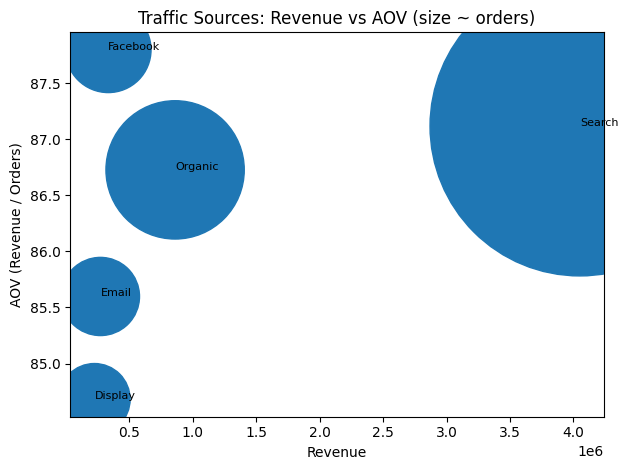

Saved: c:\dev\ecommerceproject\analysis\outputs\figures\q2_traffic_sources_revenue_vs_aov.png


In [9]:
if "traffic_perf" in locals() and len(traffic_perf):
    fig = plt.figure()
    plt.scatter(traffic_perf["revenue"], traffic_perf["aov"], s=traffic_perf["orders"])
    for _, r in traffic_perf.iterrows():
        plt.annotate(r["user_traffic_source"], (r["revenue"], r["aov"]), fontsize=8)

    plt.title("Traffic Sources: Revenue vs AOV (size ~ orders)")
    plt.xlabel("Revenue")
    plt.ylabel("AOV (Revenue / Orders)")
    plt.tight_layout()
    plt.show()

    fig_path = OUT_FIGS / "q2_traffic_sources_revenue_vs_aov.png"
    fig.savefig(fig_path, bbox_inches="tight")
    print("Saved:", fig_path)


## 3) Is slower fulfillment correlated with higher returns?
## Fulfillment speed vs returns (delivery-time deciles + correlation)


,delivery_decile,items,returned_items,return_rate,avg_ship_to_deliver_days
0,1,3383,983,0.290570,0.251733
1,2,3374,966,0.286307,0.757020
2,3,3367,945,0.280665,1.270509
3,4,3372,1029,0.305160,1.781098
4,5,3375,965,0.285926,2.284486
5,6,3376,942,0.279028,2.787588
6,7,3371,958,0.284189,3.279639
7,8,3377,924,0.273616,3.780057
8,9,3379,981,0.290323,4.271747
9,10,3366,1028,0.305407,4.758001


Saved: c:\dev\ecommerceproject\analysis\outputs\tables\q3_fulfillment_deciles.csv


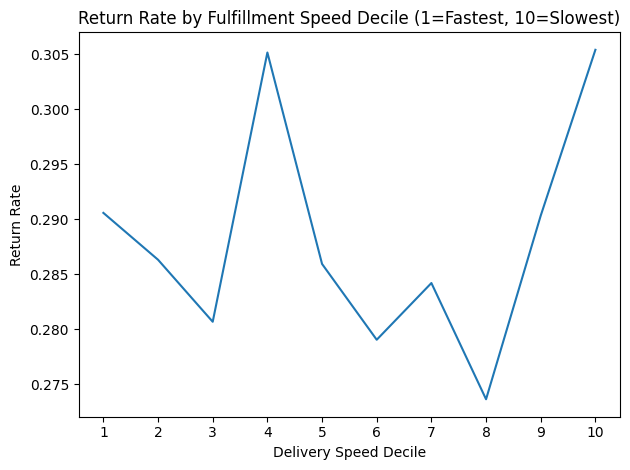

Saved: c:\dev\ecommerceproject\analysis\outputs\figures\q3_return_rate_by_fulfillment_decile.png
Correlation(ship_to_deliver_days, is_returned): 0.0027


In [10]:
ful = df.dropna(subset=["ship_to_deliver_days"]).copy()
ful = ful[(ful["ship_to_deliver_days"] >= 0)]

# Deciles computed in pandas (avoids Postgres window/group-by conflicts)
ful["delivery_decile"] = pd.qcut(ful["ship_to_deliver_days"], 10, labels=False, duplicates="drop") + 1

fulfillment_deciles = (
    ful.groupby("delivery_decile", as_index=False)
       .agg(
           items=("order_item_id","count"),
           returned_items=("is_returned","sum"),
           return_rate=("is_returned","mean"),
           avg_ship_to_deliver_days=("ship_to_deliver_days","mean"),
       )
       .sort_values("delivery_decile")
)

display(fulfillment_deciles)

fulfillment_deciles.to_csv(OUT_TABLES / "q3_fulfillment_deciles.csv", index=False)
print("Saved:", OUT_TABLES / "q3_fulfillment_deciles.csv")

fig = plt.figure()
plt.plot(fulfillment_deciles["delivery_decile"], fulfillment_deciles["return_rate"])
plt.title("Return Rate by Fulfillment Speed Decile (1=Fastest, 10=Slowest)")
plt.xlabel("Delivery Speed Decile")
plt.ylabel("Return Rate")
plt.xticks(fulfillment_deciles["delivery_decile"])
plt.tight_layout()
plt.show()

fig_path = OUT_FIGS / "q3_return_rate_by_fulfillment_decile.png"
fig.savefig(fig_path, bbox_inches="tight")
print("Saved:", fig_path)

# Optional: quick correlation (directional, not causal)
corr = ful[["ship_to_deliver_days","is_returned"]].corr().iloc[0,1]
print("Correlation(ship_to_deliver_days, is_returned):", round(float(corr), 4))


In [12]:
# Correlation at item-level: ship_to_deliver_days vs is_returned
import pandas as pd

# --- Helper: save DataFrame to analysis outputs/tables (explicit path via OUT_TABLES) ---
def save_csv(df_to_save: pd.DataFrame, filename: str):
    out_path = OUT_TABLES / filename
    df_to_save.to_csv(out_path, index=False)
    print("Saved:", out_path)

df_corr = df.dropna(subset=["ship_to_deliver_days"]).copy()

corr = df_corr["ship_to_deliver_days"].corr(df_corr["is_returned"])
print(f"Correlation (ship_to_deliver_days vs is_returned): {corr:.4f}")

# optional: show return rate by binned days (more intuitive than correlation)
df_corr["ship_days_bin"] = pd.cut(
    df_corr["ship_to_deliver_days"],
    bins=[-0.01, 1, 2, 3, 5, 7, 14, 9999],
    include_lowest=True
)

bin_summary = (
    df_corr.groupby("ship_days_bin", observed=True)  # silence FutureWarning + future-proof
      .agg(
          items=("is_returned", "size"),
          return_rate=("is_returned", "mean"),
          avg_days=("ship_to_deliver_days", "mean"),
      )
      .reset_index()
)

display(bin_summary)
save_csv(bin_summary, "fulfillment_binned_return_rate.csv")


Correlation (ship_to_deliver_days vs is_returned): 0.0027


,ship_days_bin,items,return_rate,avg_days
0,"(-0.011, 1.0]",6706,0.288548,0.500232
1,"(1.0, 2.0]",6570,0.289041,1.505526
2,"(2.0, 3.0]",6740,0.284421,2.502588
3,"(3.0, 5.0]",13724,0.289274,4.005230


Saved: c:\dev\ecommerceproject\analysis\outputs\tables\fulfillment_binned_return_rate.csv


## 4) Revenue and margin over time by category and traffic source?
## Returns trend by month (return rate + revenue trend)


C:\Users\Asus\AppData\Local\Temp\ipykernel_23856\1234516348.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_month["month"] = df_month["created_at"].dt.to_period("M").dt.to_timestamp()


,month,order_items,returned_items,return_rate,revenue,margin_proxy,margin_rate_proxy
0,2023-01-01,1625,168,0.103385,98665.79,51248.98110,0.519420
1,2023-02-01,4530,467,0.103091,271505.07,140389.62909,0.517079
2,2023-03-01,5488,562,0.102405,326302.76,170315.63834,0.521956
3,2023-04-01,5474,544,0.099379,316383.50,163576.01188,0.517018
4,2023-05-01,5920,611,0.103209,343971.12,178382.07065,0.518596
5,2023-06-01,6178,603,0.097604,363314.14,188063.66424,0.517634
6,2023-07-01,6888,703,0.102062,417457.93,217345.92838,0.520642
7,2023-08-01,7324,702,0.095849,447580.90,232799.84386,0.520129
8,2023-09-01,7869,853,0.108400,481772.30,249955.11773,0.518824
9,2023-10-01,8886,930,0.104659,544430.90,282757.59920,0.519364


Saved: c:\dev\ecommerceproject\analysis\outputs\tables\q4_monthly_overall.csv


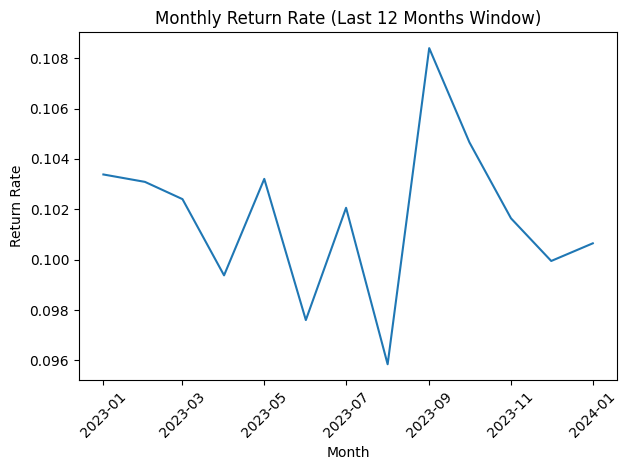

Saved: c:\dev\ecommerceproject\analysis\outputs\figures\q4_monthly_return_rate.png


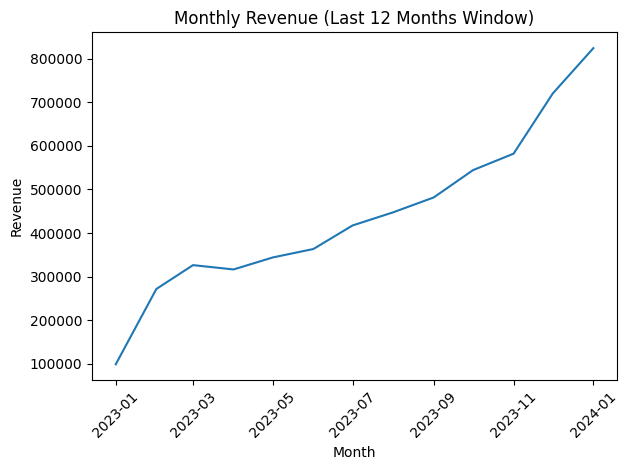

Saved: c:\dev\ecommerceproject\analysis\outputs\figures\q4_monthly_revenue.png


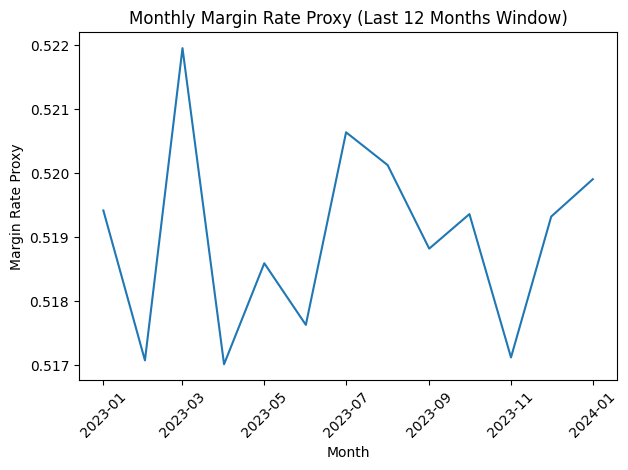

Saved: c:\dev\ecommerceproject\analysis\outputs\figures\q4_monthly_margin_rate_proxy.png


,month,category,revenue,margin_proxy,return_rate,margin_rate_proxy
0,2023-01-01,Fashion Hoodies & Sweatshirts,5653.04,2705.77095,0.147059,0.478640
1,2023-01-01,Jeans,10542.98,4919.77830,0.151786,0.466640
2,2023-01-01,Outerwear & Coats,11998.38,6732.49610,0.106667,0.561117
3,2023-01-01,Shorts,4375.29,2202.91008,0.072917,0.503489
4,2023-01-01,Sleep & Lounge,5015.37,2639.20300,0.057143,0.526223
5,2023-01-01,Suits & Sport Coats,7424.65,4488.31338,0.111111,0.604515
6,2023-01-01,Sweaters,8401.87,4263.97184,0.100917,0.507503
7,2023-01-01,Swim,5831.46,2805.16669,0.097345,0.481040
8,2023-02-01,Fashion Hoodies & Sweatshirts,16293.59,7832.82462,0.094276,0.480730
9,2023-02-01,Jeans,33660.77,15731.71164,0.105263,0.467360


Saved: c:\dev\ecommerceproject\analysis\outputs\tables\q4_monthly_by_category_top8.csv


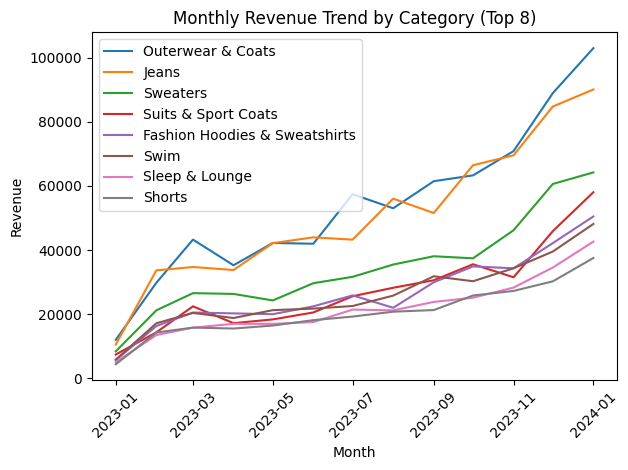

Saved: c:\dev\ecommerceproject\analysis\outputs\figures\q4_category_revenue_trend_top8.png


In [13]:
df_month = df.copy()
df_month["month"] = df_month["created_at"].dt.to_period("M").dt.to_timestamp()

monthly = (
    df_month.groupby("month", as_index=False)
            .agg(
                order_items=("order_item_id","count"),
                returned_items=("is_returned","sum"),
                return_rate=("is_returned","mean"),
                revenue=("sale_price","sum"),
                margin_proxy=("margin_proxy","sum"),
            )
            .sort_values("month")
)
monthly["margin_rate_proxy"] = monthly["margin_proxy"] / monthly["revenue"]

display(monthly)
monthly.to_csv(OUT_TABLES / "q4_monthly_overall.csv", index=False)
print("Saved:", OUT_TABLES / "q4_monthly_overall.csv")

fig = plt.figure()
plt.plot(monthly["month"], monthly["return_rate"])
plt.title("Monthly Return Rate (Last 12 Months Window)")
plt.xlabel("Month")
plt.ylabel("Return Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig_path = OUT_FIGS / "q4_monthly_return_rate.png"
fig.savefig(fig_path, bbox_inches="tight")
print("Saved:", fig_path)

fig = plt.figure()
plt.plot(monthly["month"], monthly["revenue"])
plt.title("Monthly Revenue (Last 12 Months Window)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig_path = OUT_FIGS / "q4_monthly_revenue.png"
fig.savefig(fig_path, bbox_inches="tight")
print("Saved:", fig_path)

fig = plt.figure()
plt.plot(monthly["month"], monthly["margin_rate_proxy"])
plt.title("Monthly Margin Rate Proxy (Last 12 Months Window)")
plt.xlabel("Month")
plt.ylabel("Margin Rate Proxy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig_path = OUT_FIGS / "q4_monthly_margin_rate_proxy.png"
fig.savefig(fig_path, bbox_inches="tight")
print("Saved:", fig_path)

cat_rev = (
    df_month.groupby("category", as_index=False)
            .agg(revenue=("sale_price","sum"))
            .sort_values("revenue", ascending=False)
            .head(8)
)
top_cats = cat_rev["category"].tolist()

cat_monthly = (
    df_month[df_month["category"].isin(top_cats)]
        .groupby(["month","category"], as_index=False)
        .agg(
            revenue=("sale_price","sum"),
            margin_proxy=("margin_proxy","sum"),
            return_rate=("is_returned","mean"),
        )
)
cat_monthly["margin_rate_proxy"] = cat_monthly["margin_proxy"] / cat_monthly["revenue"]

display(cat_monthly.head(20))
cat_monthly.to_csv(OUT_TABLES / "q4_monthly_by_category_top8.csv", index=False)
print("Saved:", OUT_TABLES / "q4_monthly_by_category_top8.csv")

fig = plt.figure()
for cat in top_cats:
    s = cat_monthly[cat_monthly["category"] == cat].sort_values("month")
    plt.plot(s["month"], s["revenue"], label=cat)

plt.title("Monthly Revenue Trend by Category (Top 8)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

fig_path = OUT_FIGS / "q4_category_revenue_trend_top8.png"
fig.savefig(fig_path, bbox_inches="tight")
print("Saved:", fig_path)

if "ts_monthly" in locals():
    fig = plt.figure()
    for src in top_ts:
        s = ts_monthly[ts_monthly["user_traffic_source"] == src].sort_values("month")
        plt.plot(s["month"], s["revenue"], label=src)

    plt.title("Monthly Revenue Trend by Traffic Source (Top 8)")
    plt.xlabel("Month")
    plt.ylabel("Revenue")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

    fig_path = OUT_FIGS / "q4_traffic_source_revenue_trend_top8.png"
    fig.savefig(fig_path, bbox_inches="tight")
    print("Saved:", fig_path)


### Worst categories/brands by return rate (and how much margin they burn)

"margin_burn_proxy" here = sum of (sale_price - inventory_cost) on returned items.
This is a proxy for how much gross margin exposure returns create.


In [14]:
sql_worst_cat_brand = """
WITH bounds AS (
  SELECT MAX(created_at)::timestamptz AS max_ts
  FROM thelook_analytics.v_fact_order_items_enriched
),
base AS (
  SELECT *
  FROM thelook_analytics.v_fact_order_items_enriched
  WHERE created_at::timestamptz >= (SELECT max_ts - INTERVAL '12 months' FROM bounds)
),
agg AS (
  SELECT
    category,
    brand,
    COUNT(*) AS items,
    COUNT(*) FILTER (WHERE returned_at IS NOT NULL) AS returned_items,
    ROUND(
      (COUNT(*) FILTER (WHERE returned_at IS NOT NULL))::numeric / NULLIF(COUNT(*),0),
      4
    ) AS return_rate,
    ROUND(SUM(sale_price)::numeric, 2) AS revenue,
    ROUND(SUM(sale_price - inventory_cost)::numeric, 2) AS margin_proxy,
    ROUND(
      SUM(CASE WHEN returned_at IS NOT NULL THEN (sale_price - inventory_cost) ELSE 0 END)::numeric,
      2
    ) AS margin_burn_proxy
  FROM base
  GROUP BY 1,2
)
SELECT *
FROM agg
WHERE items >= 200
ORDER BY return_rate DESC, margin_burn_proxy DESC
LIMIT 25;
"""

worst_cat_brand = run_sql(sql_worst_cat_brand)
display(worst_cat_brand)
save_csv(worst_cat_brand, "worst_category_brand_returns_margin_burn.csv")


,category,brand,items,returned_items,return_rate,revenue,margin_proxy,margin_burn_proxy
0,Jeans,Not Your Daughter's Jeans,259,37,0.1429,26334.06,12078.31,1744.86
1,Jeans,True Religion,268,35,0.1306,65201.88,30409.59,4027.45
2,Jumpsuits & Rompers,Allegra K,238,31,0.1303,3106.55,1475.69,189.64
3,Underwear,Hanes,318,40,0.1258,8584.60,4595.10,570.60
4,Dresses,Allegra K,385,48,0.1247,4592.30,2485.58,308.71
5,Underwear,Calvin Klein,346,43,0.1243,10205.74,5400.06,671.60
6,Jeans,Lucky Brand,280,34,0.1214,23467.75,11080.93,1302.68
7,Jeans,Joe's Jeans,282,34,0.1206,44806.39,20663.47,2536.60
8,Accessories,Ray-Ban,357,42,0.1176,42605.27,25644.12,3213.56
9,Fashion Hoodies & Sweatshirts,Fox,238,28,0.1176,14974.93,7326.09,898.10


Saved: c:\dev\ecommerceproject\analysis\outputs\tables\worst_category_brand_returns_margin_burn.csv


## Customer cohorts (new vs repeat): return behavior + revenue

Better cohort logic:
- first_purchase_ts computed across ALL history (not limited to the 12-month window)
- then we label items in the 12-month window as new vs repeat


,month,customer_type,order_items,orders,customers,return_rate,revenue,margin_proxy
0,2023-01-01,new_customer,677,677,677,0.1019,41805.74,21625.64
1,2023-01-01,repeat_customer,948,690,683,0.1044,56860.05,29623.34
2,2023-02-01,new_customer,1946,1946,1946,0.1053,116397.81,60230.92
3,2023-02-01,repeat_customer,2584,1826,1793,0.1014,155107.26,80158.71
4,2023-03-01,new_customer,2335,2335,2335,0.1122,135231.45,70087.86
5,2023-03-01,repeat_customer,3153,2175,2122,0.0951,191071.31,100227.78
6,2023-04-01,new_customer,2244,2244,2244,0.0949,130144.19,67367.01
7,2023-04-01,repeat_customer,3230,2264,2211,0.1025,186239.31,96209.00
8,2023-05-01,new_customer,2440,2440,2440,0.1025,139538.78,71911.63
9,2023-05-01,repeat_customer,3480,2393,2328,0.1037,204432.34,106470.44


Saved: c:\dev\ecommerceproject\analysis\outputs\tables\cohorts_new_vs_repeat_monthly.csv
Saved: c:\dev\ecommerceproject\analysis\outputs\figures\cohorts_return_rate_new_vs_repeat.png


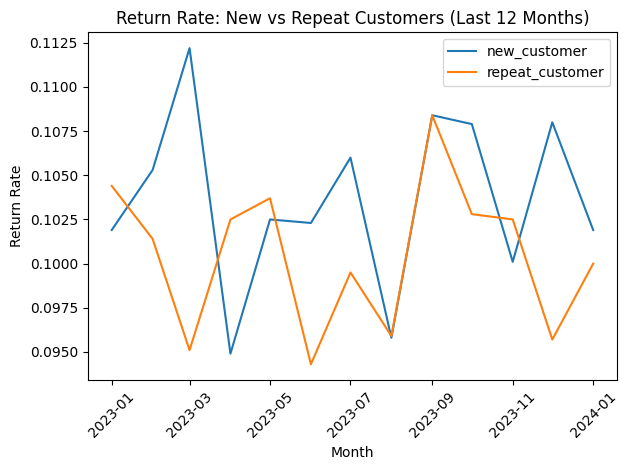

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper: save plot to analysis outputs/figures (explicit path via OUT_FIGS) ---
def save_fig(filename: str):
    out_path = OUT_FIGS / filename
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    print("Saved:", out_path)

sql_cohorts = """
WITH bounds AS (
  SELECT MAX(created_at)::timestamptz AS max_ts
  FROM thelook_analytics.v_fact_order_items_enriched
),
windowed AS (
  SELECT *
  FROM thelook_analytics.v_fact_order_items_enriched
  WHERE created_at::timestamptz >= (SELECT max_ts - INTERVAL '12 months' FROM bounds)
),
first_purchase AS (
  SELECT
    user_id,
    MIN(created_at)::timestamptz AS first_purchase_ts
  FROM thelook_analytics.v_fact_order_items_enriched
  GROUP BY 1
),
labeled AS (
  SELECT
    w.*,
    fp.first_purchase_ts,
    CASE
      WHEN w.created_at::timestamptz = fp.first_purchase_ts THEN 'new_customer'
      ELSE 'repeat_customer'
    END AS customer_type
  FROM windowed w
  JOIN first_purchase fp USING (user_id)
)
SELECT
  date_trunc('month', created_at)::date AS month,
  customer_type,
  COUNT(*) AS order_items,
  COUNT(DISTINCT order_id) AS orders,
  COUNT(DISTINCT user_id) AS customers,
  ROUND(
    (COUNT(*) FILTER (WHERE returned_at IS NOT NULL))::numeric / NULLIF(COUNT(*),0),
    4
  ) AS return_rate,
  ROUND(SUM(sale_price)::numeric, 2) AS revenue,
  ROUND(SUM(sale_price - inventory_cost)::numeric, 2) AS margin_proxy
FROM labeled
GROUP BY 1,2
ORDER BY 1,2;
"""

cohorts = run_sql(sql_cohorts)
display(cohorts)
save_csv(cohorts, "cohorts_new_vs_repeat_monthly.csv")

# Pivot for plotting (safe even if one category is missing)
pivot_rr = (
    cohorts.pivot(index="month", columns="customer_type", values="return_rate")
           .sort_index()
           .reset_index()
)

plt.figure()
if "new_customer" in pivot_rr.columns:
    plt.plot(pivot_rr["month"], pivot_rr["new_customer"], label="new_customer")
if "repeat_customer" in pivot_rr.columns:
    plt.plot(pivot_rr["month"], pivot_rr["repeat_customer"], label="repeat_customer")

plt.title("Return Rate: New vs Repeat Customers (Last 12 Months)")
plt.xlabel("Month")
plt.ylabel("Return Rate")
plt.xticks(rotation=45)
plt.legend()

save_fig("cohorts_return_rate_new_vs_repeat.png")
plt.show()
